# DCSI 592: Capstone II

## Predicting Crop Yield in Colorado: Modeling

Dataset: https://catalog.data.gov/dataset/usda-ars-colorado-maize-water-productivity-dataset-2012-2013-f9f68


## 0.0 Imports, Helper Functions & Loading Data

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [1]:
def display_scores(scores):
    print(f"\tScores: {scores}")
    print(f"\tMean: {scores.mean():.2f}")
    print(f"\tStd Deviation: {scores.std():.2f}")
    return

# apply log transformation and add a constant to deal with 0s
def apply_log_transform_with_constant(dataframe, constant=1e-5):
    # Copy the input dataframe to avoid modifying the original data
    transformed_df = dataframe.copy()
        # Apply logarithmic transformation to numeric columns
    for col in transformed_df.select_dtypes(include=['number']).columns:
        # Add a small constant value to avoid zero values
        transformed_df[col] = np.log(transformed_df[col] + constant)
    return transformed_df

def display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description):
    print(f'{model_description.upper()}')
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Training R2: {train_r2:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    print(f'Test R2: {test_r2:.2f}')
    print(f'Cross-Validation RMSE:')
    display_scores(cross_val_rmse)
    return

In [3]:
FILE = 'cleaned_annual_data.csv'
maize_data = pd.read_csv(FILE)
maize_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 1   Max_LAI                      94 non-null     float64
 2   Annual_ETc mm                94 non-null     float64
 3   Trt_code                     94 non-null     int64  
 4   Plant density plants ha-1    94 non-null     float64
 5   HI                           94 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 4.5 KB


For our model, we will predict `grain yield` using: 
- irrigation `treatment code` (numerical value that represents the watering deprivation treatment used: the lower value treatments (1, 2, 3...) received more water, while higher values (9, 10, 11...) got less during both periods.Table in appendix)
- `plant density`
- `max leaf area index`

Concept: if a farmer was facing a drought (limited water supply), could they use a model to optimize their watering and still achieve grain yield goals?

In [4]:
features = ["Grain Yield_15.5%mc_Kg ha-1", "Trt_code","Plant density plants ha-1", "Max_LAI"]
maize_model_data = maize_data[features]

### 0.1 Log Transformation

In [5]:
log_transformed_model_data = apply_log_transform_with_constant(maize_data)
log_transformed_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 1   Max_LAI                      94 non-null     float64
 2   Annual_ETc mm                94 non-null     float64
 3   Trt_code                     94 non-null     float64
 4   Plant density plants ha-1    94 non-null     float64
 5   HI                           94 non-null     float64
dtypes: float64(6)
memory usage: 4.5 KB


### 0.2 Winsorization Transformation


In [6]:
# Winsorize the data
limits = [0.05, 0.05]
winsorized_model_data = maize_model_data.apply(lambda x: winsorize(x, limits=limits) if x.dtype != 'O' else x)
winsorized_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 1   Trt_code                     94 non-null     int64  
 2   Plant density plants ha-1    94 non-null     float64
 3   Max_LAI                      94 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 3.1 KB


# Modeling
## 1.0 Linear Regression: Baseline (no transformation)

In [7]:
# define features as `X` and target variable (Grain Yield) as `y`   
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model 
linear_regression_model = LinearRegression()

# train the model
linear_regression_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = linear_regression_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = linear_regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# perform cross-validation on the training set
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_mse = cross_val_score(linear_regression_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# evaluate model
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="linear regression (baseline)")

LINEAR REGRESSION (BASELINE)
Training MSE: 2184176.26
Training R2: 0.39
Test MSE: 3737592.99
Test R2: 0.39
Cross-Validation RMSE:
	Scores: [1069.05034353 1488.4381728  1851.74256705 1643.49770468 1684.88701516]
	Mean: 1547.52
	Std Deviation: 265.73


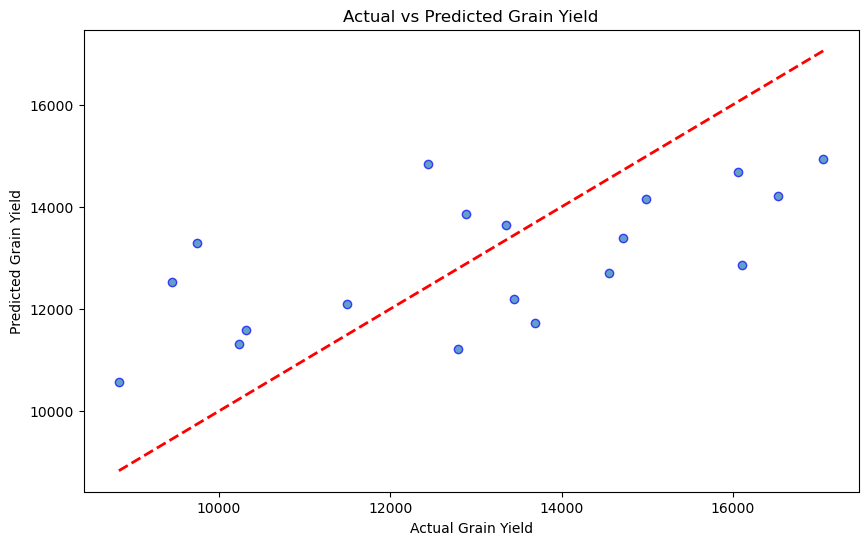

In [8]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors=(0, 0, 1))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Grain Yield')
plt.ylabel('Predicted Grain Yield')
plt.title('Actual vs Predicted Grain Yield')
plt.show()

### Looking at model coefficients -- Ordered from most to least significant impact on grain yield: Treatment Code, Max Leaf Area Index, and Plant Density 

The coefficients for this model tell us:
- `Trt_code`: Strong negative relationship with grain yield. For every 1 unit increase in `Treatment_code` (which reduces water usage), the grain yield is expected to decrease by ~338.83 Kg / h1 units. (~746.99 lbs)
- `Plant density plants ha-1`: Very weak positive relationship with grain yield. The impact of plant density is minimal. Every 1 unit increase in this coef, grain yield should increase by 0.03 Kg / h1 units (~.07 lbs) 
- `Max_LAI`: Strong positive relationship with grain yield. This feature has a significant impact on grain yield. For every 1 unit increase in max leaf area, grain yield should increase by 527.54 Kg / h1 units (~1,163.03)

_Note: 1 hectare = 2.47 acres, or 107,639 square feet_

In [9]:
# Get feature names
feature_names = X.columns

# Extract and display the coefficients
coefs = pd.DataFrame(
linear_regression_model.coef_,
    columns=["Coefficients"],
    index=feature_names
)

coefs

,Coefficients
Trt_code,-338.829080
Plant density plants ha-1,0.036397
Max_LAI,527.542289


## 1.1 Linear Regression with log transformation

In [10]:
# define features as `X` and target variable (Grain Yield) as `y`   
X = log_transformed_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = log_transformed_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model 
linear_regression_model = LinearRegression()

# train the model
linear_regression_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = linear_regression_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = linear_regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# perform cross-validation on the training set
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_mse = cross_val_score(linear_regression_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# evaluate model
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="linear regression (log transformed)")

# # Plotting
# fig, ax = plt.subplots(figsize=(15, 6))
# plot_cv_indices(cv, X_train, y_train, ax, n_splits=5, rmse_scores=cross_val_rmse)
# plt.show()

LINEAR REGRESSION (LOG TRANSFORMED)
Training MSE: 0.01
Training R2: 0.44
Test MSE: 0.02
Test R2: 0.46
Cross-Validation RMSE:
	Scores: [0.14255537 0.11757067 0.12756701 0.13771425 0.11715205]
	Mean: 0.13
	Std Deviation: 0.01


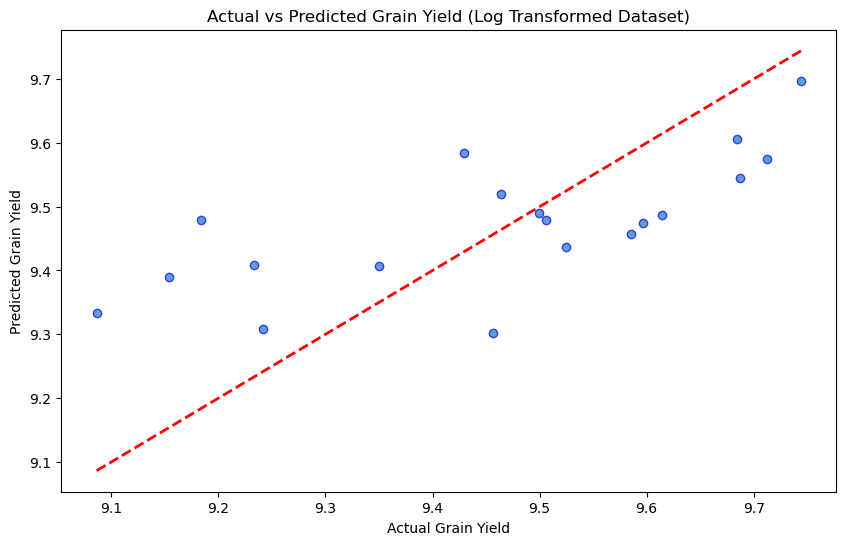

In [11]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors=(0, 0, 1))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Grain Yield')
plt.ylabel('Predicted Grain Yield')
plt.title('Actual vs Predicted Grain Yield (Log Transformed Dataset)')
plt.show()

### 1.2 Winsorized data - linear regression

In [12]:
# define features as `X` and target variable (Grain Yield) as `y`   
X = winsorized_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = winsorized_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model 
linear_regression_model = LinearRegression()

# train the model
linear_regression_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = linear_regression_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = linear_regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# perform cross-validation on the training set
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_mse = cross_val_score(linear_regression_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# evaluate model
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="linear regression (winsorized)")

LINEAR REGRESSION (WINSORIZED)
Training MSE: 1961667.32
Training R2: 0.39
Test MSE: 3380966.05
Test R2: 0.36
Cross-Validation RMSE:
	Scores: [1075.56338576 1498.93476024 1771.24051162 1418.40091686 1585.47306447]
	Mean: 1469.92
	Std Deviation: 229.42


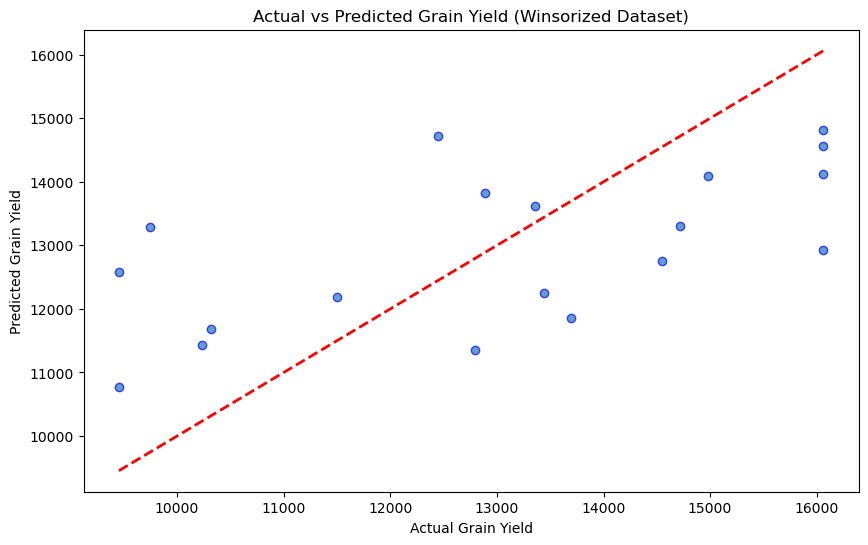

In [13]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors=(0, 0, 1))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Grain Yield')
plt.ylabel('Predicted Grain Yield')
plt.title('Actual vs Predicted Grain Yield (Winsorized Dataset)')
plt.show()

# 2.0 Ridge Regression 
<br>No transformations to data




In [14]:
from sklearn.linear_model import Ridge

# define features as `X` and target variable (Grain Yield) as `y`   
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model
ridge_regression_model = Ridge()

# Train the model
ridge_regression_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = ridge_regression_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = ridge_regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Perform cross-validation on the training set
cross_val_mse = cross_val_score(ridge_regression_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# Display model results
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="ridge regression")

RIDGE REGRESSION
Training MSE: 2184481.33
Training R2: 0.39
Test MSE: 3745429.18
Test R2: 0.39
Cross-Validation RMSE:
	Scores: [1071.58524771 1490.46252048 1843.61387529 1642.73413043 1686.27146901]
	Mean: 1546.93
	Std Deviation: 262.97


# 3.0 Random Forest 
No transformations to data

In [15]:
from sklearn.ensemble import RandomForestRegressor

# define features as `X` and target variable (Grain Yield) as `y`   
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = random_forest_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = random_forest_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Perform cross-validation on the training set
cross_val_mse = cross_val_score(random_forest_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# Display model results
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="random forest regression")


RANDOM FOREST REGRESSION
Training MSE: 337910.88
Training R2: 0.91
Test MSE: 2997232.27
Test R2: 0.51
Cross-Validation RMSE:
	Scores: [1375.60015109 1403.80854384 1755.36718191 1447.81573266 1555.08981815]
	Mean: 1507.54
	Std Deviation: 138.14


### Feature importance
Treatment code (watering) is most important while plant density is the least important

In [16]:
# get feature importance from Random Forest model
feature_importances = random_forest_model.feature_importances_
features = X.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
0,Trt_code,0.593663
2,Max_LAI,0.233148
1,Plant density plants ha-1,0.173189


# 4.0 Gradient Boosting Regression
No transformations to data

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# define features as `X` and target variable (Grain Yield) as `y`   
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

# Train the model
gradient_boosting_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = gradient_boosting_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = gradient_boosting_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Perform cross-validation on the training set
cross_val_mse = cross_val_score(gradient_boosting_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# Display model results
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="gradient boosting regression")


GRADIENT BOOSTING REGRESSION
Training MSE: 87514.88
Training R2: 0.98
Test MSE: 3221642.34
Test R2: 0.47
Cross-Validation RMSE:
	Scores: [1702.91830086 1351.16105587 2091.64401905 1465.55226351 1588.95907242]
	Mean: 1640.05
	Std Deviation: 254.72


## 3.1 Radom Forest (Tuned)
Hyperparameter tuning to optimize the random forest model.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the model
random_forest_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_dist, 
                                   n_iter=50, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, verbose=2)

# Perform random search
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found by RandomizedSearchCV:")
print(random_search.best_params_, "\n")

# Get the best estimator
best_rf_model = random_search.best_estimator_

# Calculate training MSE and R2
y_train_pred = best_rf_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = best_rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Perform cross-validation on the training set
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_mse = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# Display model results
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="tuned random forest regression")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found by RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None} 

TUNED RANDOM FOREST REGRESSION
Training MSE: 1067877.80
Training R2: 0.70
Test MSE: 2983862.97
Test R2: 0.51
Cross-Validation RMSE:
	Scores: [1291.09791741 1335.94317209 1710.1045883  1447.85260468 1540.68706847]
	Mean: 1465.14
	Std Deviation: 150.33


___________________________

# Appendix



| **Trt Code** | **Irr Treatment (late veg/grain filling)** |
|--------------|-------------------|
| 1            | 100/100           |
| 2            | 100/50            |
| 3            | 80/80             |
| 4            | 80/65             |
| 5            | 80/50             |
| 6            | 80/40             |
| 7            | 65/80             |
| 8            | 65/65             |
| 9            | 65/50             |
| 10           | 65/40             |
| 11           | 50/50             |
| 12           | 40/40             |